In [1]:
import numpy as np
import pycuda.driver as cuda
from gpuocean.utils import Common

gpu_ctx = Common.CUDAContext()

In [2]:
Nx = 150 # size with ghost cells 
Ny = 75 # size with ghost cells

nx = Nx - 4 # size without ghost cells
ny = Ny - 4 # size without ghost cells

In [3]:
defines={'block_width': 12, 'block_height': 32,
        'KPSIMULATOR_DESING_EPS': "{:.12f}f".format(0.1),
        'KPSIMULATOR_FLUX_SLOPE_EPS': "{:.12f}f".format(0.1),
        'KPSIMULATOR_DEPTH_CUTOFF': "{:.12f}f".format(1.0e-5),
        'THETA': "{:.12f}f".format(1.3),
        'RK_ORDER': int(2),
        'NX': int(nx),
        'NY': int(ny),
        'DX': "{:.12f}f".format(100),
        'DY': "{:.12f}f".format(100),
        'GRAV': "{:.12f}f".format(10.0),
        'FRIC': "{:.12f}f".format(0.0),
        'RHO_O': "{:.12f}f".format(1025.0)
        }

In [4]:
kernel = gpu_ctx.get_kernel("CDKLM16_kernel.cu", 
                defines=defines, 
                compile_args={                          # default, fast_math, optimal
                    'options' : ["--ftz=true",          # false,   true,      true
                                 "--prec-div=false",    # true,    false,     false,
                                 "--prec-sqrt=false",   # true,    false,     false
                                 "--fmad=false"]        # true,    true,      false
                    
                    #'options': ["--use_fast_math"]
                    #'options': ["--generate-line-info"], 
                    #nvcc_options=["--maxrregcount=39"],
                    #'arch': "compute_50", 
                    #'code': "sm_50"
                },
                jit_compile_args={
                    #jit_options=[(cuda.jit_option.MAX_REGISTERS, 39)]
                }
                )

c:\Users\florianb\Miniconda3\envs\gpuocean_opendrift\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  from ipykernel import kernelapp as app


In [5]:
gpu_stream = cuda.Stream()

In [6]:
field = np.repeat(np.arange(Nx)[np.newaxis], Ny, axis=0).astype(np.float32)

In [7]:
## Set texture
GPUtexref = kernel.get_texref("angle_tex")

gpu_stream.synchronize()
gpu_ctx.synchronize()

GPUtexref.set_array(cuda.np_to_array(field, order="C"))
GPUtexref.set_filter_mode(cuda.filter_mode.LINEAR) #bilinear interpolation
GPUtexref.set_address_mode(0, cuda.address_mode.CLAMP) #no indexing outside domain
GPUtexref.set_address_mode(1, cuda.address_mode.CLAMP)
GPUtexref.set_flags(cuda.TRSF_NORMALIZED_COORDINATES) #Use [0, 1] indexing

gpu_ctx.synchronize()

In [8]:
## Bug?
# When nx/ny is devidable by the local size then there is no ceiling,
# And then there are not enough grid cells to cover NX x NY (with ghost cells)
# Use e.g. 100 for NX or NY

In [9]:
## Sample texture
local_size = (defines["block_width"], defines["block_height"], 1) 
global_size = (int(np.ceil(nx / float(local_size[0]))), int(np.ceil(ny / float(local_size[1]))) ) # ATTENTION: Different to sim definition!!!


texref = Common.CUDAArray2D(gpu_stream, Nx, Ny, 0, 0, np.zeros((Ny,Nx)))
get_tex = kernel.get_function("get_texture")
get_tex.prepare("Pi")
get_tex.prepared_async_call(global_size, local_size, gpu_stream, texref.data.gpudata, np.int32(0))

In [10]:
nx / float(local_size[0])

12.166666666666666

In [11]:
ny / float(local_size[1])

2.21875

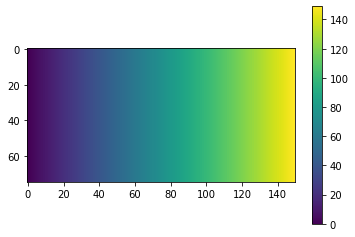

In [12]:
from matplotlib import pyplot as plt

plt.imshow(texref.data.get())
plt.colorbar()